## Import Libraries

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Manipulation Tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Models and Evaluations from Scikit-Learn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# Titanic Survival Classification

## 1. Problem
Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## 2. Data
The data has been split into two groups, a training and test data set. Definition of the features can be found here: https://www.kaggle.com/c/titanic/data

## 3. Evaluation
The evaluation metric being used for this problem is *accuracy*, which is based on the percentage of passengers you correctly predict.

## 4. Features
Use the above link from *Data* in order to see a Data Dictionary. Some important notes:
- Survived: 0 = No, 1 = Yes
- Pclass (Ticket Class): 1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower)
- Embarked: C = Cherbourg, Q = Queenstown, S = Southampton

## 5. Modeling

### 5.1 Data Exploration (Exploratory Data Anlysis)

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


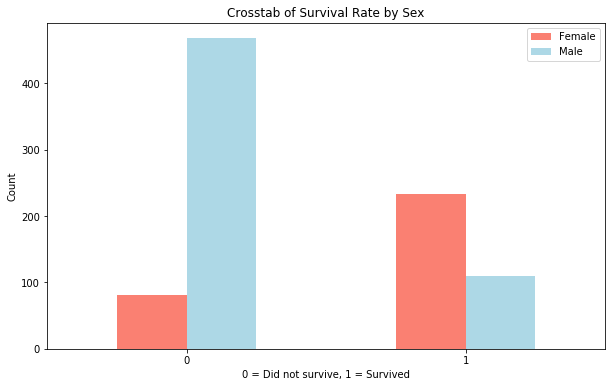

From this chart, we can see that 5.778 times more males than females did not survive.
We can also see that 2.138 times more females females survived than males


In [3]:
pd.crosstab(train_df.Survived, train_df.Sex).plot(kind='bar', figsize=(10,6), color=['salmon', 'lightblue'])
plt.title('Crosstab of Survival Rate by Sex')
plt.xlabel('0 = Did not survive, 1 = Survived')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(['Female', 'Male'])
plt.show()

# Calculate the difference in survival/death rates based on Sex (round to 3 decimals)
survive_count = train_df['Survived'].groupby(train_df['Sex']).value_counts()
male_death, female_death = survive_count[2], survive_count[1]
male_surv, female_surv = survive_count[3], survive_count[0]
print('From this chart, we can see that {} times more males than females did not survive.'
      .format(np.round((male_death/female_death),3)))
print('We can also see that {} times more females females survived than males'
      .format(np.round((female_surv/male_surv),3)))

In [4]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

##### We will want to make the following changes to our datasets:
- Fill missing values in *Age* column with the median value.
- Convert *Sex* column to numeric columns
- Fill *Embarked* column with most occuring value and convert to numeric
- Drop *Cabin* column, *Name* column, and *Ticket* column

In [5]:
def data_set_manipulations(train_df, test_df):
    labels = [train_df, test_df]
    for dataset in labels:
       # Fill missing values in Age column with the median
        dataset['Age'] = dataset['Age'].fillna(value=dataset['Age'].median())

        # Convert Sex column to numeric
        encoder = LabelEncoder()
        encoder.fit(['male', 'female'])
        dataset['Sex'] = encoder.transform(dataset['Sex'])

        # Fill Embarked with 'S' (most occuring) and concert to numeric
        dataset['Embarked'] = dataset['Embarked'].fillna(value='S')
        encoder2 = LabelEncoder()
        encoder2.fit(['S', 'C', 'Q'])
        dataset['Embarked'] = encoder2.transform(dataset['Embarked'])

        # Drop the Cabin, Name, & Ticket columns
        dataset.drop(labels =['Cabin', 'Ticket', 'Name'], inplace=True, axis=1)    
    return (train_df, test_df)


train_df, test_df = data_set_manipulations(train_df, test_df)

In [6]:
train_df.isna().sum() # no more missing values

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [7]:
# One missing values in test data set
test_df.loc[test_df['Fare'].isnull()]
test_df['Fare'] = test_df['Fare'].fillna(value=test_df['Fare'].mean())

test_df.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [8]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2


In [9]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,1
1,893,3,0,47.0,1,0,7.0000,2
2,894,2,1,62.0,0,0,9.6875,1
3,895,3,1,27.0,0,0,8.6625,2
4,896,3,0,22.0,1,1,12.2875,2


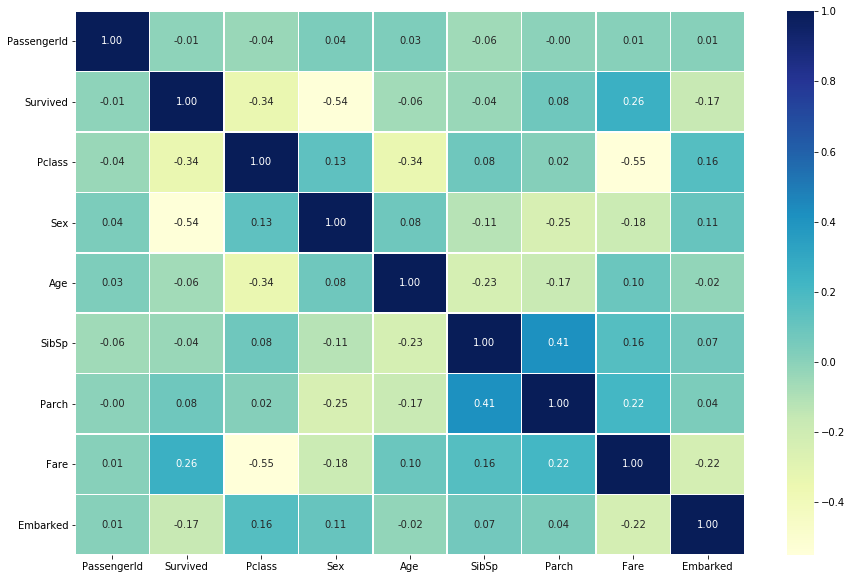

In [10]:
corr_matrix = train_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f', cmap='YlGnBu')

### 5.2 Choosing the right Estimator
We will want to test multiple classification models on our dataset in order to choose which best fits our problem. We can create a dictionary of them and run them through a function that fits/evaluates them.

#### Begin by splitting data into training/validation sets, then normalizing

In [11]:
X = train_df.drop(labels='Survived', axis=1)
y = train_df['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) # 712 (Train), 179 (Val)

def data_normalize(X_train, X_val):
    """
    Normalize data using a MinMaxScaler (all data in range [0,1])
    returns a tuple in the form (train set, validation set)
    """
    # Normalize Train Data
    train_scaler = MinMaxScaler()
    train_scaler.fit(X_train)
    X_train_norm = train_scaler.transform(X_train)
    # Normalize Test Data
    test_scaler = MinMaxScaler()
    test_scaler.fit(X_val)
    X_val_norm = test_scaler.transform(X_val)
    
    return (X_train_norm, X_val_norm)

X_train, X_val = data_normalize(X_train, X_val)

#### Test various models on our data sets

In [12]:
np.random.seed(42)

model_dict = {'Logistic': LogisticRegression(),
              'KNN': KNeighborsClassifier(),
              'RandomForest': RandomForestClassifier(),
              'LinearSVC': LinearSVC()}

def train_and_score(model_dict, X_train, X_val, y_train, y_val):
    """
    Train and fit various models using the training and validation sets.
    model_dict contains a dictionary of models and their names.
    """
    model_scores = {}
    for name, model in model_dict.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_val, y_val)
    return model_scores

train_and_score(model_dict, X_train, X_val, y_train, y_val)

{'Logistic': 0.8100558659217877,
 'KNN': 0.7932960893854749,
 'RandomForest': 0.8100558659217877,
 'LinearSVC': 0.8212290502793296}

In [16]:
gs_svc_grid = {'C': np.linspace(.5, 5, 30),
               'max_iter': [1000, 2000]}

gs_svc = GridSearchCV(LinearSVC(), param_grid=gs_svc_grid, cv=5, verbose=True)
gs_svc.fit(X_train, y_train)
print(gs_svc.best_params_)
gs_svc.score(X_val, y_val)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 4.224137931034483, 'max_iter': 1000}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.8s finished


0.8212290502793296

#### Tune the Hyperparameters of our LogisticRegression
We will use both RandomizedSearchCV and GridSearchCV to find the optimal parameters to get the highest accuracy possible.

In [17]:
np.random.seed(42)

log_rs_grid = {'C': np.linspace(1.5, 2.7, 50),
               'solver': ['liblinear', 'lbfgs'],
               'max_iter': [1000, 2000, 5000, 10000]}

log_rs = RandomizedSearchCV(LogisticRegression(), param_distributions=log_rs_grid, cv=5, n_iter=20, verbose=True)

log_rs.fit(X_train, y_train)
print(log_rs.best_params_)
log_rs.score(X_val, y_val)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'solver': 'liblinear', 'max_iter': 10000, 'C': 1.8673469387755102}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


0.8212290502793296

In [26]:
np.random.seed(42)

rf_gs_grid = {'n_estimators': np.arange(100, 700, 100)}

rf_gs = GridSearchCV(RandomForestClassifier(), param_grid=rf_gs_grid, cv=5, verbose=True)

rf_gs.fit(X_train, y_train)
print(rf_gs.best_params_)
rf_gs.score(X_val, y_val)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.2s finished


{'n_estimators': 500}


0.8212290502793296

#### Predict on test data and save to csv

Current highest model: model_2

Current model score: 77.27%

In [33]:
def final_train_and_predict(model):
    """
    Split data, normalize it with MinMaxScaler, train our model,
    and make predictions. Returns an array of estimated survival.
    """
    X_train = train_df.drop(labels='Survived', axis=1) # use full training set
    y_train = train_df['Survived']

    train_scaler = MinMaxScaler()
    train_scaler.fit(X_train)
    X_train_norm = train_scaler.transform(X_train) # normalize training set

    test_scaler = MinMaxScaler()
    train_scaler.fit(test_df)
    X_test_norm = train_scaler.transform(test_df) # normalize test set

    model.fit(X_train_norm, y_train)
    y_preds = model.predict(X_test_norm) # predict values for test set
    return y_preds

In [30]:
model = LogisticRegression(C = 2.4827586206896552, max_iter=1000, solver='lbfgs') # 76.32%
model_2 = RandomForestClassifier(n_estimators = 500) # 77.27%

y_preds = final_train_and_predict(model_2)

In [31]:
results = pd.DataFrame({'PassengerId': test_df['PassengerId'],
                        'Survived': y_preds})
results.to_csv('My_submission.csv', index=False)